In [10]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data

from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

import json

In [11]:
cpu_count = mp.cpu_count()
print(cpu_count)

12


In [12]:
pretrained_size = (120, 400)
data_path = "data/"

In [29]:
class LicensePlateDataset(Dataset):
    def __init__(self, data_path):
        super().__init__()
        self.data_path = data_path
        self.config = json.load(open(os.path.join(data_path, "license_dataset.json")))

    def abc_len(self):
        return len(self.config["vocabs"])

    def get_abc(self):
        return self.config["vocabs"]

    def __len__(self):
        return len(self.config['train'])

    def __getitem__(self, idx):
        name = self.config['train'][idx]["name"]
        text = self.config['train'][idx]["text"]
        
        image = Image.open(os.path.join(self.data_path, name)).convert('RGB')
        image = self.transform(image)

        return image, text
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize(pretrained_size),
            transforms.RandomRotation(5),
            transforms.RandomCrop(pretrained_size, padding = 10),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [30]:
datasets = LicensePlateDataset(data_path)
print(len(datasets)) 

652


In [31]:
VALID_RATIO = 0.8

n_train_examples = int(len(datasets) * VALID_RATIO)
n_valid_examples = len(datasets) - n_train_examples

In [32]:
train_data, valid_data = data.random_split(datasets, 
                                           [n_train_examples, n_valid_examples])
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 521
Number of validation examples: 131


In [33]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_images(images, labels, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (8, 8))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(labels[i])
        ax.axis('off')

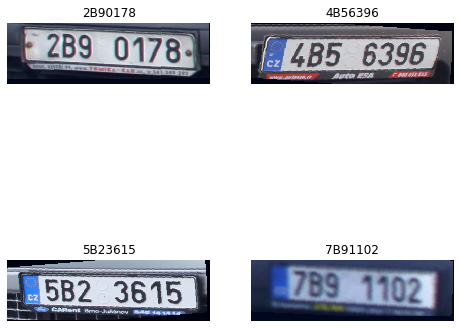

In [34]:
N_IMAGES = 4

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

plot_images(images, labels)

In [35]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
print(len(train_loader), len(test_loader))

33 9


In [36]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([16, 3, 120, 400]) ('4B82840', '4B82295', '3B38140', '4B76148', '5B99527', '7B29430', '2B73768', '9B59729', '4Z42407', '1BB6338', '5B11181', '5B77379', '9B98777', '7B11607', 'BZ04966', '2B75836')


In [38]:
num_chars = len(datasets.get_abc())
print(num_chars)
rnn_hidden_size = 256

36


In [39]:
idx2char = {k:v for k,v in enumerate(datasets.get_abc(), start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: '0', 27: '1', 28: '2', 29: '3', 30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9'}
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


## Model

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [41]:
resnet = resnet18(pretrained=True)

In [42]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(2048, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [43]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [44]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(crnn):,} trainable parameters')

The model has 6,085,220 trainable parameters


In [46]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
('4B82840', '4B82295', '3B38140', '4B76148', '5B99527', '7B29430', '2B73768', '9B59729', '4Z42407', '1BB6338', '5B11181', '5B77379', '9B98777', '7B11607', 'BZ04966', '2B75836')
torch.Size([22, 16, 36])


## Define Loss 

In [47]:
criterion = nn.CTCLoss(blank=0)

In [48]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [49]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
#     print(text_batch_logps.shape)
#     print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [50]:
print(text_batch)

('4B82840', '4B82295', '3B38140', '4B76148', '5B99527', '7B29430', '2B73768', '9B59729', '4Z42407', '1BB6338', '5B11181', '5B77379', '9B98777', '7B11607', 'BZ04966', '2B75836')


## Training

In [51]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [52]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [53]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [54]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [56]:
import time

In [57]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    start_time = time.monotonic()
    
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print("Train Loss:{} ".format(epoch_loss))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

In [58]:
#saving trained model

torch.save(crnn.state_dict(), 'output/crnn_50.pt')

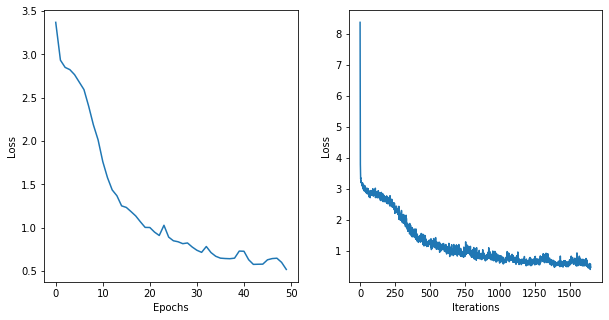

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")

ax2.set_ylabel("Loss")

plt.show()

## predictions 

In [60]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [61]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [62]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(train_data, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

In [63]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(valid_data, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
torch.Size([16, 256, 8, 22])
torch.Size([16, 22, 256, 8])
torch.Size([16, 22, 2048])
torch.Size([16, 22, 256])
torch.Size([16, 22, 256])
torch.Size([16, 22, 512])
torch.Size([16, 22, 36])
torch.Size([22, 16, 36])
torch.Size([16, 256, 8, 25])
tor

In [64]:
print(results_train.shape)
results_train.head()

(521, 2)


,actual,prediction
0,2B90178,2BBAAAAAA9900001177888
1,4B56396,4BBAAAAAAA555663339966
2,5B23615,5BBAAAAAAA223336611155
3,7B91102,7BBAAAAAAA9911A1100222
4,5Z40181,55AAAZAAAA440001188111


In [65]:
print(results_test.shape)
results_test.head()

(131, 2)


,actual,prediction
0,2B74289,2BBAAAAAA7774422288899
1,3Z63187,33AAAZAAAA663331188877
2,5B29670,5BBAAAAAAA229996677700
3,5H68504,55AAAAAA66688855000444
4,8B10162,8BBAAAAAAA111001116622


In [66]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,2B90178,2BBAAAAAA9900001177888,2BA90178
1,4B56396,4BBAAAAAAA555663339966,4BA56396
2,5B23615,5BBAAAAAAA223336611155,5BA23615
3,7B91102,7BBAAAAAAA9911A1100222,7BA91A102
4,5Z40181,55AAAZAAAA440001188111,5AZA40181


In [67]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,2B74289,2BBAAAAAA7774422288899,2BA74289
1,3Z63187,33AAAZAAAA663331188877,3AZA63187
2,5B29670,5BBAAAAAAA229996677700,5BA29670
3,5H68504,55AAAAAA66688855000444,5A68504
4,8B10162,8BBAAAAAAA111001116622,8BA10162


## Evaluate model

In [68]:
mistakes_df = results_train[results_train['actual'] != results_train['prediction_corrected']]
print(mistakes_df.head(), mistakes_df.shape)

    actual              prediction prediction_corrected
0  2B90178  2BBAAAAAA9900001177888             2BA90178
1  4B56396  4BBAAAAAAA555663339966             4BA56396
2  5B23615  5BBAAAAAAA223336611155             5BA23615
3  7B91102  7BBAAAAAAA9911A1100222            7BA91A102
4  5Z40181  55AAAZAAAA440001188111            5AZA40181 (508, 3)


In [69]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
print(mistakes_df.head(), mistakes_df.shape)

    actual              prediction prediction_corrected
0  2B74289  2BBAAAAAA7774422288899             2BA74289
1  3Z63187  33AAAZAAAA663331188877            3AZA63187
2  5B29670  5BBAAAAAAA229996677700             5BA29670
3  5H68504  55AAAAAA66688855000444              5A68504
4  8B10162  8BBAAAAAAA111001116622             8BA10162 (125, 3)


In [70]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

8     70
9     24
7     19
10     5
6      4
5      1
4      1
3      1
Name: prediction_corrected, dtype: int64


In [71]:
mask = mistakes_df['prediction_corrected'].str.len() == 6
mistakes_df[mask]

,actual,prediction,prediction_corrected
11,9B83305,7BAAAAAAAAAAAA33000555,7BA305
20,5M56740,3BAAAAAAAA222AA2222222,3BA2A2
48,8B77932,8BBAAAAAAAAAAA77799333,8BA793
63,B8547,BBBAAAAAAAA88885544777,BA8547


/opt/Ml projects/assignment_idfy/data/crop_h1/I00000.png


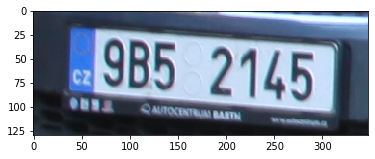

In [72]:
mistake_image_fp = '/opt/Ml projects/assignment_idfy/data/crop_h1/I00000.png'
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

In [73]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.02495201535508637
0.04580152671755725
